In [109]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)
from torchvision import datasets, transforms
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read Data

### COMPAS DATASET

In [111]:
compas = pd.read_csv("COMPAS_ProPublica/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

### ADULT DATASET

In [113]:
adult = pd.read_csv("UCIAdult/adult.csv",
                   dtype={0:int, 1:str, 2:int, 3:str, 4:int, 5: str, 6:str , 7:str ,8:str ,9: str, 10:int, 11:int, 12:int, 13:str,14: str})
print(adult.columns.to_list())

# Then drop Column
adult = adult.drop(['native-country'], axis=1)
adult = adult.drop(['fnlwgt'], axis=1)
adult = adult.drop(['capital-gain'], axis=1)
adult = adult.drop(['capital-loss'], axis=1)

# get rid of NAN vales
full_data = adult

str_list=[]

for data in [full_data]:
    for colname, colvalue in data.items(): 
        if type(colvalue[1]) == str:
            str_list.append(colname) 
num_list = data.columns.difference(str_list)

full_size = full_data.shape[0]
print('Dataset size Before pruning: ', full_size)
for data in [full_data]:
    for i in full_data:
        data[i].replace('nan', np.nan, inplace=True)
    data.dropna(inplace=True)
real_size = full_data.shape[0]
print('Dataset size after pruning: ', real_size)
print('We eliminated ', (full_size-real_size), ' datapoints')

### make prediction labels ### 
full_labels = full_data['income'].copy()
print(full_labels.shape[0])

full_data = full_data.drop(['income'], axis=1)
print(full_data.shape[0])

# Label Encode Labels
label_encoder = LabelEncoder()
full_labels = label_encoder.fit_transform(full_labels)


### Deal with categorical data ###

cat_data = full_data.select_dtypes(include=['object']).copy()
other_data = full_data.select_dtypes(include=['int']).copy()

newcat_data = pd.get_dummies(cat_data, columns = ['workclass', 'education',
       'marital-status', 'occupation', 'relationship', 'race'], dtype=int)

full_data = pd.concat([other_data, newcat_data], axis=1)
adult = full_data
adult_labels = full_labels

# one_hot = F.one_hot(torch.Tensor(adult_labels).to(torch.int).long(), 2)
# adult_labels = one_hot
# adult_labels = adult_labels.numpy()
adult['gender'] = adult['gender'].map({'Male': 0, 'Female': 1})


['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Dataset size Before pruning:  48842
Dataset size after pruning:  48842
We eliminated  0  datapoints
48842
48842


/tmp/ipykernel_39567/2817830992.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].replace('nan', np.nan, inplace=True)


In [114]:
adult

,age,educational-num,hours-per-week,gender,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,25,7,40,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,38,9,50,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,28,12,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,44,10,40,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,30,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,38,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
48838,40,9,40,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
48839,58,9,40,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
48840,22,9,20,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


### DataLoaders

In [115]:
from torch.utils.data import Dataset

In [116]:
class MyDataset(Dataset):    
    def __init__(self, dataframe, targets, transform=None):
        self.data_frame = dataframe
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        m_data = self.data_frame.iloc[idx, :].values
        m_target = self.targets[idx]
        m_data = m_data.astype('float')
        m_target = m_target.astype('float')
        sample = {'target': np.array([m_target]), 'data': np.array(m_data)}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [117]:
adultDataset = MyDataset(adult, adult_labels)

In [118]:
indices = list(range(len(adultDataset)))
random.shuffle(indices)

bs = 1028
batch_size_eval = 128

# Split dataset into train and Test sets
adult_train_loader = DataLoader(
    adultDataset,
    batch_size=bs,
    sampler=SubsetRandomSampler(indices[:30001]),
    num_workers=1,
)

adult_valid_loader = DataLoader(
    adultDataset,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[30001:38001]),
    num_workers=1,
)

adult_test_loader = DataLoader(
    adultDataset,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[38001:]),
    num_workers=1,
)

## Model

In [119]:
class Wide(nn.Module):
    def __init__(self, num_features_in, num_classes):
        super().__init__()
        self.hidden = nn.Linear(num_features_in, 180)
        self.relu = nn.ReLU()
        self.hidden1 = nn.Linear(180, 90)
        self.output = nn.Linear(90, num_classes)
        self.dropout = nn.Dropout(0.25)
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

In [120]:
class Deep(nn.Module):
    def __init__(self,num_features_in, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(num_features_in, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

## ENGINE

In [136]:
def train(model, train_loader, optimizer, epoch, lossFunc):
    model.train()
    
    for data in train_loader:
        inputs = data["data"]
        target = data["target"]
        inputs, target = inputs.to(torch.float32), target.to(torch.float32)
        target = target.type(torch.LongTensor)
        inputs, target = inputs.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(inputs)

        target = torch.squeeze(target, dim=1)

        loss = lossFunc(output, target, inputs)
        # loss = lossFunc(output, target)
        
        # Backprop
        loss.backward()
        optimizer.step()
        ###

def test(model, test_loader, lossFunc):
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad():
      
        for data in test_loader:
            inputs = data["data"]
            target = data["target"]
            inputs, target = inputs.to(torch.float32), target.to(torch.float32)
            target = target.type(torch.LongTensor)
            inputs, target = inputs.to(device), target.to(device)
            
            output = model(inputs)
            test_size += len(inputs)

            target = torch.squeeze(target, dim=1)
            
            test_loss += lossFunc(output, target).item()
            # test_loss += lossFunc(output, target).item() 
            # indicies of max pred
            pred = output.max(1, keepdim=True)[1]
            
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

## Vanilla Accuracy Run Code

In [124]:
num_features = 62
model = Wide(num_features, 2).to(device)
test_accuracy = []
train_loss = []
nbr_epochs = 25
lr = 0.0001
weight_decay = 0



# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=lr ,weight_decay=weight_decay)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)


print('Training beginning...')
start_time = time.time()

for epoch in range(1, nbr_epochs+1):
    print('Epoch ', epoch, ':')
    train(model, adult_train_loader, optimizer, epoch, loss_fn)
    loss, acc = test(model, adult_valid_loader, test_loss_fn)
    
    # save results every epoch
    test_accuracy.append(acc)
    train_loss.append(loss)
    
end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')

test_loss, test_acc = test(model, adult_test_loader, test_loss_fn)
print(test_loss, test_acc)

Training beginning...
Epoch  1 :

Test set: Average loss: 0.5940, Accuracy: 6094/8000 (76%)

Epoch  2 :

Test set: Average loss: 0.5678, Accuracy: 6094/8000 (76%)

Epoch  3 :

Test set: Average loss: 0.5591, Accuracy: 6094/8000 (76%)

Epoch  4 :

Test set: Average loss: 0.5514, Accuracy: 6094/8000 (76%)

Epoch  5 :

Test set: Average loss: 0.5421, Accuracy: 6094/8000 (76%)

Epoch  6 :

Test set: Average loss: 0.5306, Accuracy: 6094/8000 (76%)

Epoch  7 :

Test set: Average loss: 0.5167, Accuracy: 6094/8000 (76%)

Epoch  8 :

Test set: Average loss: 0.5019, Accuracy: 6094/8000 (76%)

Epoch  9 :

Test set: Average loss: 0.4839, Accuracy: 6129/8000 (77%)

Epoch  10 :

Test set: Average loss: 0.4641, Accuracy: 6238/8000 (78%)

Epoch  11 :

Test set: Average loss: 0.4438, Accuracy: 6373/8000 (80%)

Epoch  12 :

Test set: Average loss: 0.4255, Accuracy: 6435/8000 (80%)

Epoch  13 :

Test set: Average loss: 0.4104, Accuracy: 6505/8000 (81%)

Epoch  14 :

Test set: Average loss: 0.3989, Accura

In [125]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, "modelDicts/vanilla_no_cap.pt")

## Demographic Parity

In [ ]:
adult.columns.to_list()

In [154]:
## define the combination of accuracy and demographic parity regularization
def demoParityLoss(outputs, targets, samples, parityCoef=10000.0):
    ## accuracy
    entropy_fn = nn.CrossEntropyLoss()
    entropy_loss = entropy_fn(outputs, targets)

    columns = adult.columns.to_list()
    # sensitive_classes = ['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black','race_Other', 'race_White']
    # sensitive_index = [columns.index(i) for i in sensitive_classes]
    # sensitive_accuracies = []
    # ## parity
    # for i in sensitive_index:
    #     sample_race_col = samples[:, i]
    #     sample_race_indicies = sample_race_col == 1
    #     race_outputs = outputs[sample_race_indicies]
    #     race_targets = targets[sample_race_indicies]

    #     race_pred = race_outputs.max(1, keepdim=True)[1]

    gen_acc = []
    gen_ind = columns.index('gender')
    for i in range(0,2):
        gender_mask = samples[:, gen_ind] == i
        gender_outputs = outputs[gender_mask]
        gender_targets = targets[gender_mask]

        gender_pred = gender_outputs.max(1, keepdim=True)[1]
        gender_correct = gender_pred.eq(gender_targets.view_as(gender_pred)).sum().item()
        
        gen_acc.append(gender_correct/gender_mask.size()[0])

    gen_acc = torch.Tensor(gen_acc)
    parity = torch.diff(gen_acc)
    parity = torch.abs(parity)
    parity = parityCoef * parity
    parity = parity.to(device)
    parity.requires_grad_()
    
    loss = entropy_loss + parity
    
    return loss

In [156]:
num_features = 62
demModel = Wide(num_features, 2).to(device)
test_accuracy = []
train_loss = []
nbr_epochs = 25
lr = 0.0001
weight_decay = 0

# Surrogate loss used for training
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(demModel.parameters(), lr=lr,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=lr ,weight_decay=weight_decay)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)


print('Training beginning...')
start_time = time.time()

for epoch in range(1, nbr_epochs+1):
    print('Epoch ', epoch, ':')
    train(demModel, adult_train_loader, optimizer, epoch, demoParityLoss)
    loss, acc = test(demModel, adult_valid_loader, test_loss_fn)
    
    # save results every epoch
    test_accuracy.append(acc)
    train_loss.append(loss)
    
end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')

test_loss, test_acc = test(demModel, adult_test_loader, test_loss_fn)
print(test_loss, test_acc)

Training beginning...
Epoch  1 :

Test set: Average loss: 0.5969, Accuracy: 6094/8000 (76%)

Epoch  2 :

Test set: Average loss: 0.5723, Accuracy: 6094/8000 (76%)

Epoch  3 :

Test set: Average loss: 0.5629, Accuracy: 6094/8000 (76%)

Epoch  4 :

Test set: Average loss: 0.5528, Accuracy: 6094/8000 (76%)

Epoch  5 :

Test set: Average loss: 0.5416, Accuracy: 6094/8000 (76%)

Epoch  6 :

Test set: Average loss: 0.5289, Accuracy: 6094/8000 (76%)

Epoch  7 :

Test set: Average loss: 0.5134, Accuracy: 6094/8000 (76%)

Epoch  8 :

Test set: Average loss: 0.4963, Accuracy: 6094/8000 (76%)

Epoch  9 :

Test set: Average loss: 0.4783, Accuracy: 6101/8000 (76%)

Epoch  10 :

Test set: Average loss: 0.4607, Accuracy: 6172/8000 (77%)

Epoch  11 :

Test set: Average loss: 0.4435, Accuracy: 6401/8000 (80%)

Epoch  12 :

Test set: Average loss: 0.4245, Accuracy: 6453/8000 (81%)

Epoch  13 :

Test set: Average loss: 0.4115, Accuracy: 6542/8000 (82%)

Epoch  14 :

Test set: Average loss: 0.3994, Accura

In [157]:
torch.save({'model_state_dict': demModel.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, "modelDicts/10000_coef_parity_no_cap.pt")

## Interpretabiliy

In [126]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [180]:
interp_model = Wide(62,2)
checkpoint = torch.load("modelDicts/10000_coef_parity_no_cap.pt", weights_only=True)
interp_model.load_state_dict(checkpoint['model_state_dict'])
interp_model.to(device)

Wide(
  (hidden): Linear(in_features=62, out_features=180, bias=True)
  (relu): ReLU()
  (hidden1): Linear(in_features=180, out_features=90, bias=True)
  (output): Linear(in_features=90, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [181]:
ig = IntegratedGradients(interp_model)

In [182]:
ig_attr = ig.attribute(torch.Tensor(adult[38001:].to_numpy()).to(device), 
                                    target=torch.Tensor(adult_labels[38001:]).to(torch.int64).to(device))
ig_mean = torch.mean(ig_attr, dim=0)

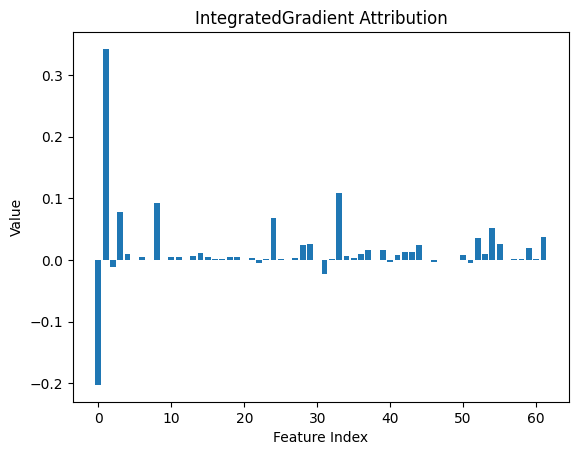

In [183]:
# plot feature wise attribution of each class
# Convert tensor to a NumPy array (Matplotlib works with NumPy)
data_np = ig_mean.cpu().numpy()

# Create a histogram with 65 bins (one bar per value)
plt.bar(range(62), data_np, width=0.8)  # Use `range(65)` for x-coordinates

# Add labels and title
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.title("IntegratedGradient Attribution")

# Display the plot
plt.show()

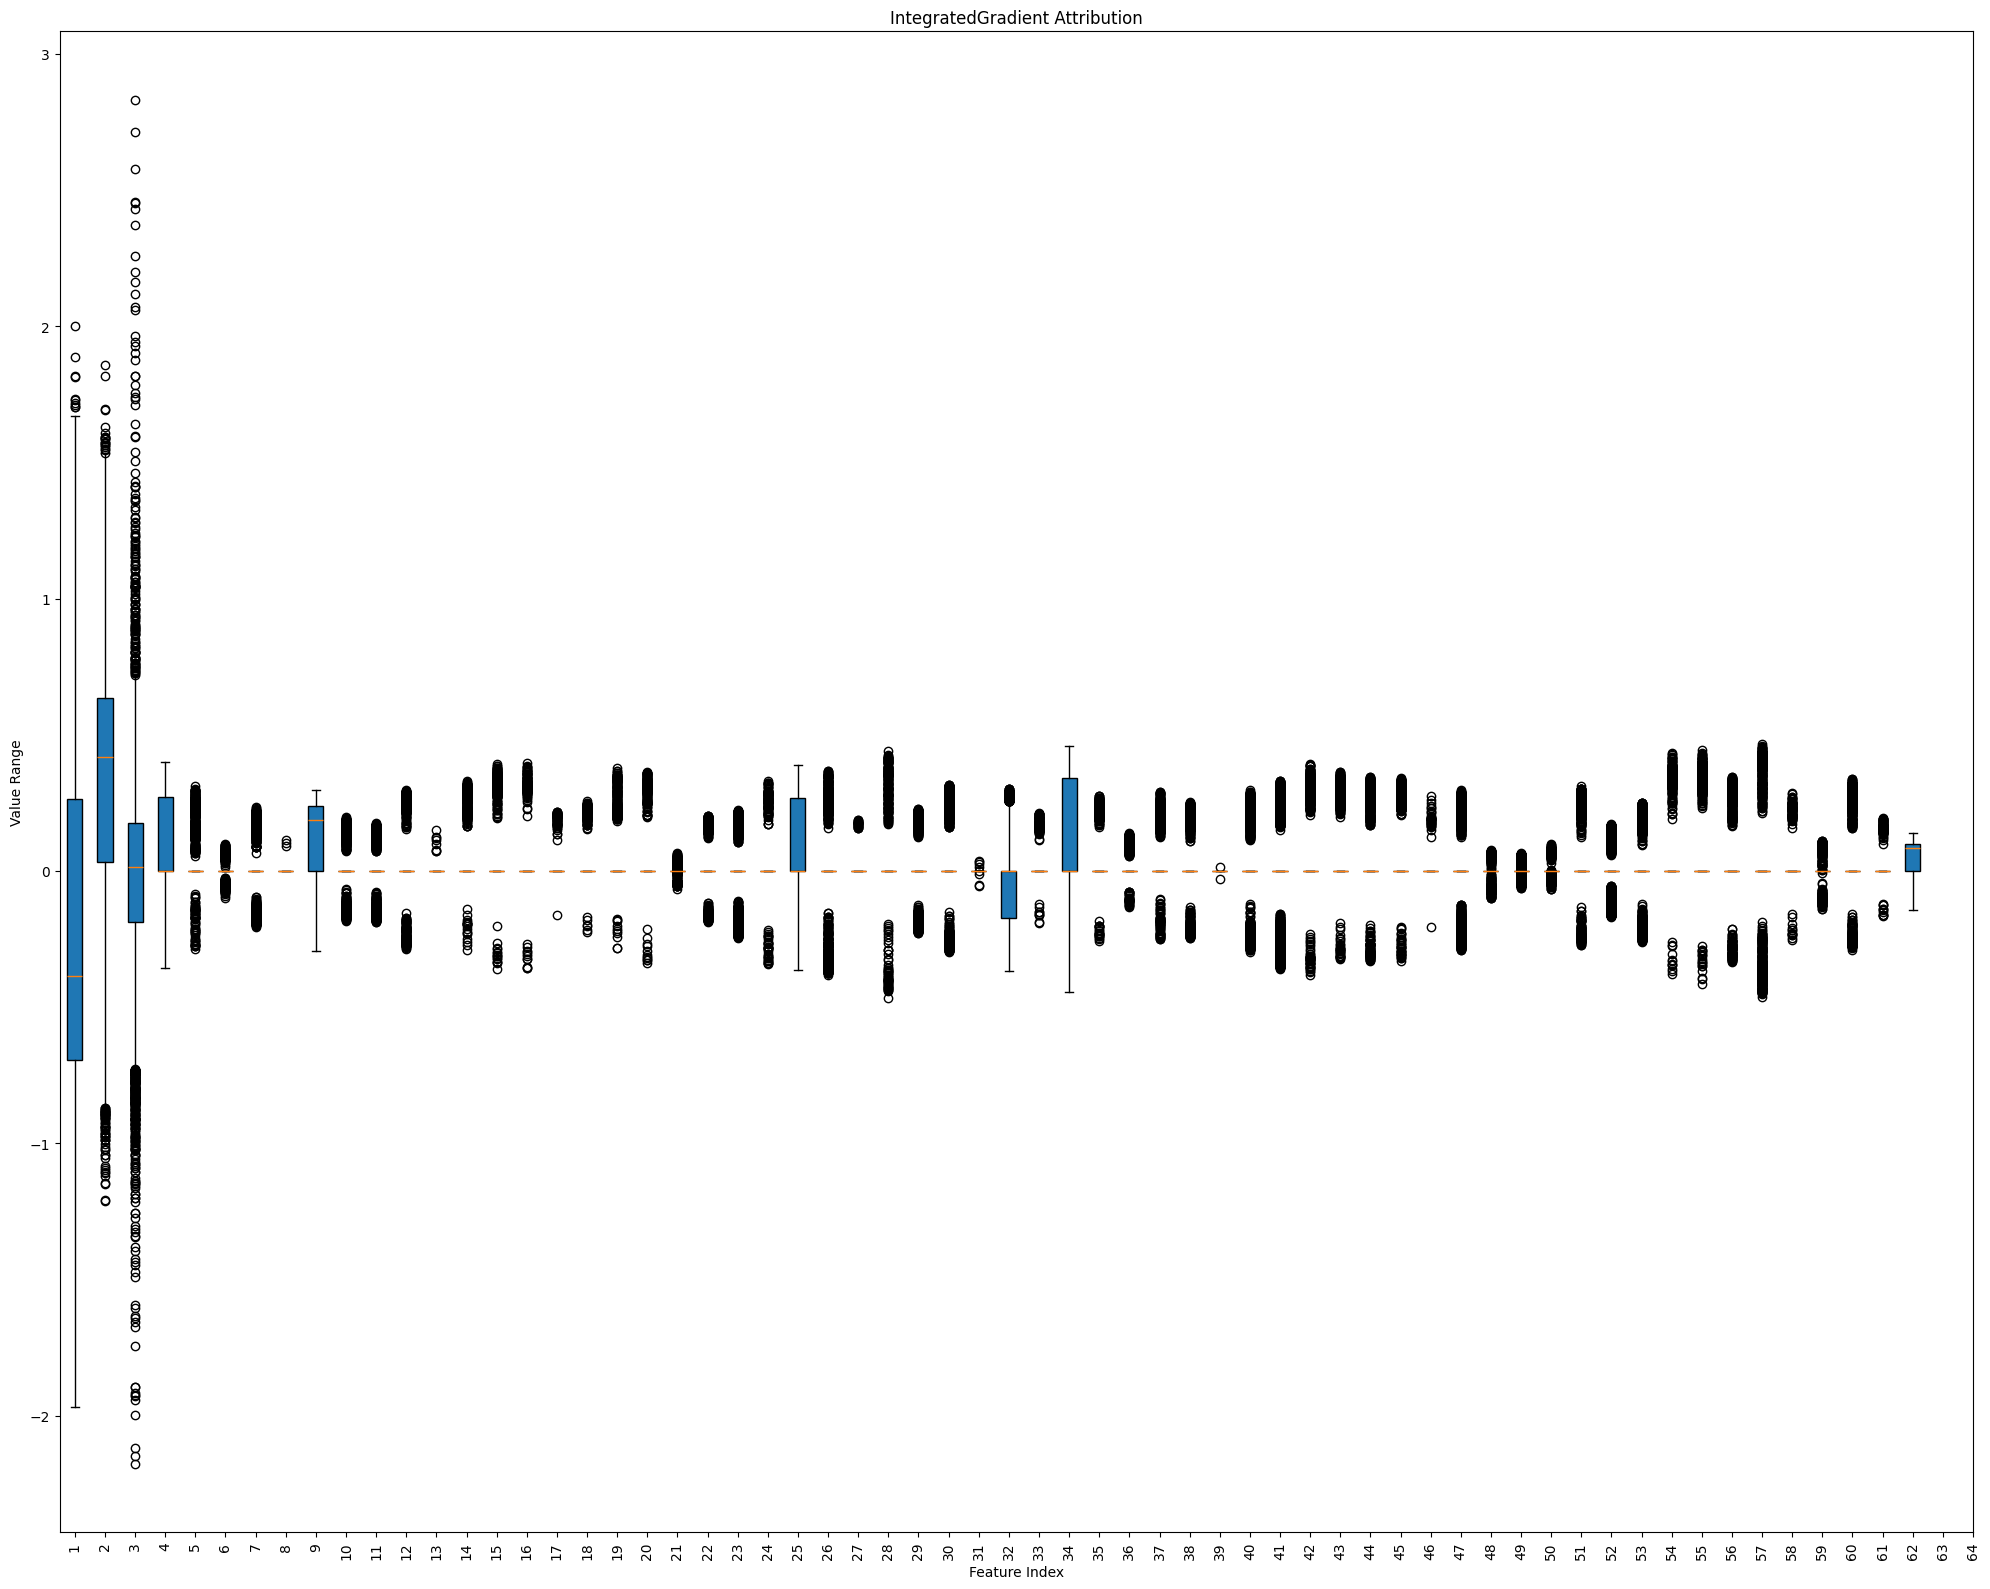

In [184]:
# Create the boxplot
data_box = ig_attr.cpu().numpy()

plt.figure(figsize=(20, 16))  # Set the figure size
plt.boxplot(data_box, vert=True, patch_artist=True)

# Add labels and title
plt.xlabel("Feature Index")
plt.ylabel("Value Range")
plt.title("IntegratedGradient Attribution")

# Customize x-axis ticks
plt.xticks(ticks=range(1, 65), labels=range(1, 65), rotation=90)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [185]:
top_ten = torch.topk(torch.abs(ig_mean), 10)
top_ten_ind = top_ten[1]

In [186]:
categories = adult.columns.tolist()
top_cat = [categories[i] for i in top_ten_ind.cpu().numpy().tolist()]

In [187]:
top_cat

['educational-num',
 'age',
 'marital-status_Never-married',
 'workclass_Private',
 'gender',
 'education_HS-grad',
 'relationship_Own-child',
 'race_White',
 'relationship_Not-in-family',
 'marital-status_Divorced']